<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_PyTorchTraining/blob/main/IG_PedObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell

wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2023-06-23 12:41:27--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  11.6MB/s    in 5.3s    

2023-06-23 12:41:33 (9.70 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-06-23 12:41:33--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-06-23 12:41:33--
Total wall clock time: 6.3s
Downloaded: 1 files, 51M in 5.3s (9.70 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [2]:
from PIL import Image

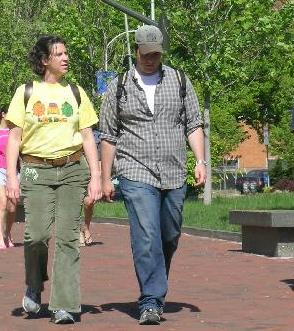

In [3]:
Image.open("PennFudanPed/PNGImages/PennPed00096.png")

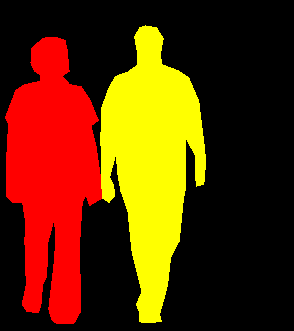

In [4]:
mask = Image.open("PennFudanPed/PedMasks/PennPed00096_mask.png")
mask = mask.convert('P')
mask.putpalette([
    0,0,0,
    255,0,0,
    255,255,0,
    255,150,0
])

mask

In [5]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

In [6]:
root_dir = "PennFudanPed"

In [7]:
os.path.join(root_dir, "PNGImages")

'PennFudanPed/PNGImages'

In [8]:
sorted(os.listdir(os.path.join(root_dir, "PNGImages")))[:5]

['FudanPed00001.png',
 'FudanPed00002.png',
 'FudanPed00003.png',
 'FudanPed00004.png',
 'FudanPed00005.png']

In [9]:
# images = sorted(os.listdir(os.path.join(root_dir, "PNGImages")))
# masks = sorted(os.listdir(os.path.join(root_dir, "PedMasks")))

In [10]:
# images[0]

In [11]:
# os.path.join(root_dir, "PNGImages", images[0])

In [12]:
# mask_img = os.path.join(root_dir, "PedMasks", masks[2])

In [13]:
# mask_img = Image.open(mask_img)

In [14]:
# mask_img = np.array(mask_img)

In [15]:
# mask_img.shape

In [16]:
# obj_id = np.unique(mask_img)

In [17]:
# mask_img

In [18]:
# obj_id = obj_id[1:]

In [19]:
# obj_id

In [20]:
# masks = mask_img == obj_id[:, None, None]

In [21]:
# masks

In [22]:
# masks.shape

In [23]:
# pos = np.nonzero(masks[0])

In [24]:
# pos[0].shape

In [25]:
# np.min(pos[0])

In [26]:
# torch.ones((2,), dtype=torch.int64)

In [143]:
import cv2

class PedDataset(Dataset):
  def __init__(self, root_dir, transforms=None):
    self.root_dir = root_dir
    self.transforms = transforms

    self.images = list(sorted(os.listdir(os.path.join(root_dir, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root_dir, "PedMasks"))))

  def __getitem__(self, index):
    flag = True
    img_path = os.path.join(self.root_dir, "PNGImages", self.images[index])
    mask_path = os.path.join(self.root_dir, "PedMasks", self.masks[index])
    # Read image using PIL Image package
    img = Image.open(img_path).convert("RGB")
    # read mask image
    mask = Image.open(mask_path)
    # convert PIL image into numpy array
    mask = np.array(mask)
    # mask = cv2.resize(mask, (380, 423))
    obj_ids = np.unique(mask)
    # exclude 0th index, because 0th index is background color
    obj_ids = obj_ids[1:]
    # get binary mask only...
    # now it will set our mask image as either true or false
    masks = mask == obj_ids[:, None, None]
    target = {}
    # get bounding box
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      try:
        # print("I is :",i, num_objs, masks.shape, index)
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
      except BaseException as ex:
        print(ex)

    # type cast box list into a tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    # type cast mask into tensor
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.images)

In [144]:
dataset = PedDataset(root_dir)
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F4E71A8F490>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [145]:
# FasterRCNN (Object Detection) + MaskRCNN (Segmentation)

In [146]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [147]:
# FastRCNN is pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [148]:
NUM_CLASSES = 2
# number of input features for classifier
input_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(input_features, NUM_CLASSES)

In [149]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [150]:
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# mobilenet output channel is 1280

backbone.out_channels = 1280

anchor_gen = AnchorGenerator()
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7, sampling_ratio=2)
model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_gen,
                   box_roi_pool=roi_pooler)

In [151]:
# Instance Segmentation

In [152]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [153]:
def get_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  input_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(input_features, NUM_CLASSES)

  input_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(input_features_mask,
                                                     hidden_layer,
                                                     NUM_CLASSES)
  return model

In [154]:
# %%shell
# git clone https://github.com/pytorch/vision.git

# cd vision
# cp references/detection/utils.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/coco_utils.py ../
# cp references/detection/transforms.py ../

In [155]:
# import torchvision.transforms as T
import transforms as T

In [156]:
def transformations(train):
  transforms = []
  transforms.append(T.PILToTensor())
  transforms.append(T.ConvertImageDtype(torch.float))
  # transforms.append(T.Resize(300,300))
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [133]:
# Code for testing our model (optional step)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PedDataset(root_dir, transformations(train=True))

data_loader_train = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=False, collate_fn=utils.collate_fn
)

images, target = next(iter(data_loader_train))
images = list(image for image in images)
targets = [{k:v for k,v in t.items()} for t in target]
output = model(images, target)
model.eval()
test_x = [torch.rand(3,300,400), torch.rand(3, 500, 400)]
pred = model(test_x)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [157]:
from engine import train_one_epoch, evaluate
import utils

In [158]:
dataset = PedDataset(root_dir, transformations(train=True))
test_dataset = PedDataset(root_dir, transformations(train=False))

In [159]:
indices = torch.randperm(len(dataset)).tolist()

In [160]:
indices[:5]

[169, 4, 14, 138, 162]

In [161]:
len(indices)

170

In [162]:
# in train_dataset we have 170-50 = 120 images
train_dataset = torch.utils.data.Subset(dataset, indices[:-50])
# in test_dataset we have 50 images
test_dataset = torch.utils.data.Subset(test_dataset, indices[-50:])

In [163]:
data_loader_train = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

In [179]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_segmentation(NUM_CLASSES)
model.to(device)

params = [param for param in model.parameters() if param.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [180]:
epochs = 10

for epoch in range(epochs):
  train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:34  lr: 0.000090  loss: 5.2664 (5.2664)  loss_classifier: 1.0052 (1.0052)  loss_box_reg: 0.2498 (0.2498)  loss_mask: 4.0032 (4.0032)  loss_objectness: 0.0072 (0.0072)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 0.5796  data: 0.0334  max mem: 6025
Epoch: [0]  [10/60]  eta: 0:00:27  lr: 0.000936  loss: 2.2340 (2.9044)  loss_classifier: 0.5745 (0.5903)  loss_box_reg: 0.2498 (0.2421)  loss_mask: 1.2964 (2.0423)  loss_objectness: 0.0175 (0.0247)  loss_rpn_box_reg: 0.0036 (0.0051)  time: 0.5443  data: 0.0382  max mem: 6025
Epoch: [0]  [20/60]  eta: 0:00:21  lr: 0.001783  loss: 1.0250 (1.8752)  loss_classifier: 0.2296 (0.3944)  loss_box_reg: 0.2095 (0.2343)  loss_mask: 0.4517 (1.2144)  loss_objectness: 0.0233 (0.0257)  loss_rpn_box_reg: 0.0049 (0.0064)  time: 0.5406  data: 0.0332  max mem: 6025
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.002629  loss: 0.5868 (1.4482)  loss_classifier: 0.1148 (0.2981)  loss_box_reg: 0.1959 (0.2252)  loss_mask: 0.2471 (0.8971)  loss_ob

In [181]:
img, _ = test_dataset[4]

In [182]:
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

In [184]:
# prediction

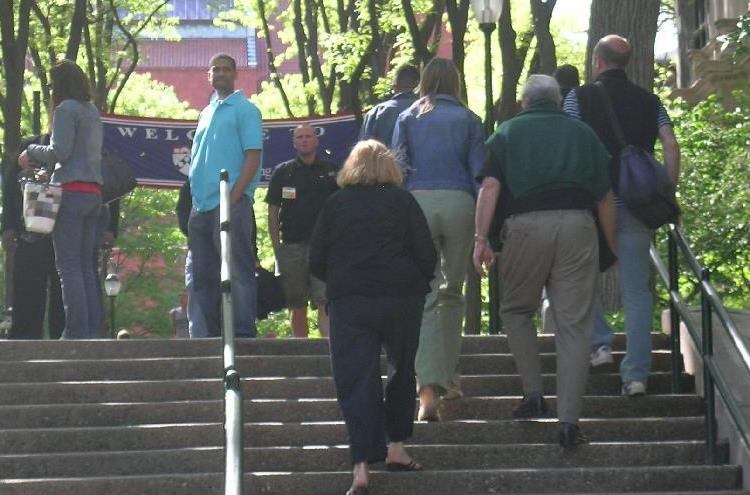

In [185]:
Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy())

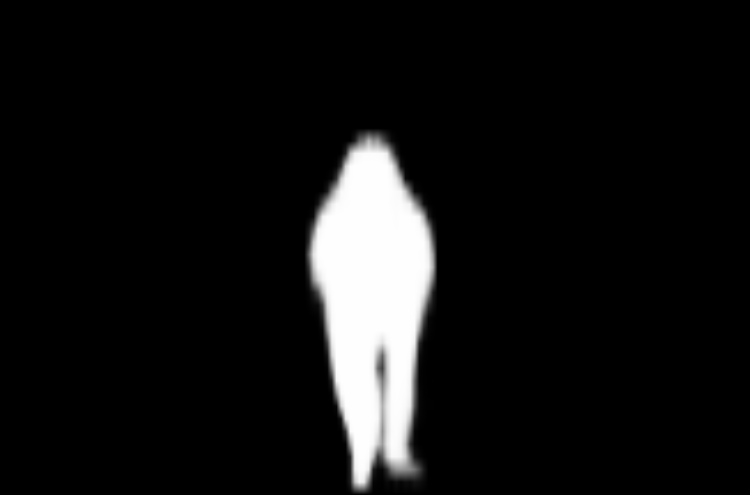

In [190]:
Image.fromarray(prediction[0]['masks'][0,0].mul(255).byte().cpu().numpy())

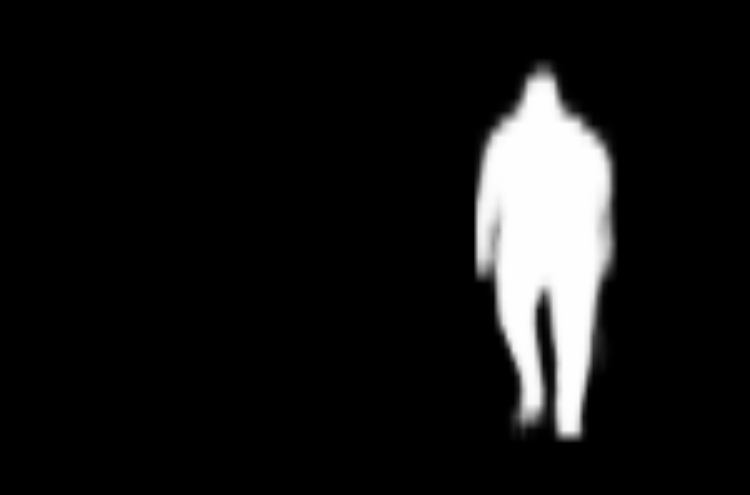

In [195]:
Image.fromarray(prediction[0]['masks'][1,0].mul(255).byte().cpu().numpy())

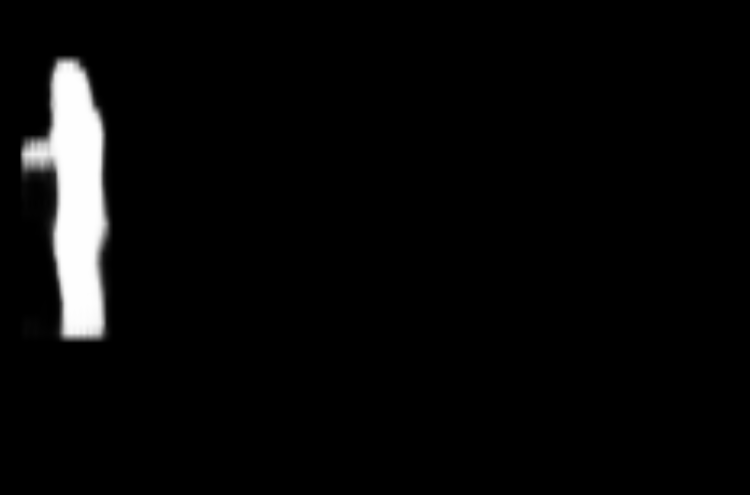

In [196]:
Image.fromarray(prediction[0]['masks'][2,0].mul(255).byte().cpu().numpy())

In [207]:
x,y,w,h = prediction[0]['boxes'][2]

In [208]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# img = Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy())
draw = ImageDraw.Draw(img)
draw.rectangle(((x, y), (w, h)))

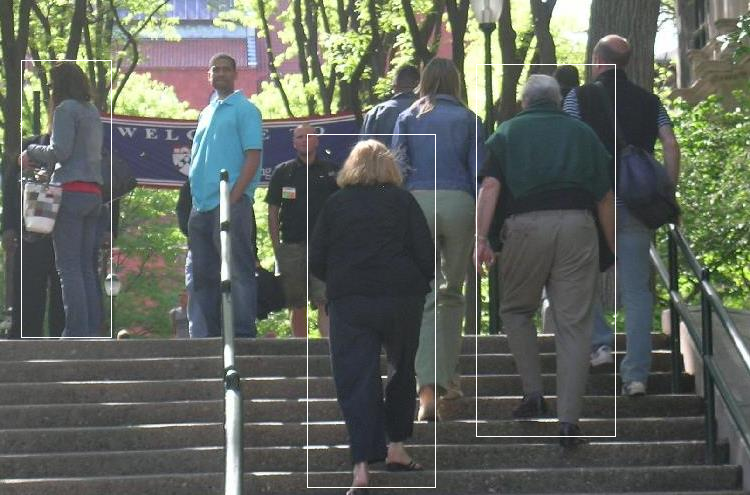

In [209]:
img